Q1 

In [66]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df_portfolio = pd.read_csv("initial_portfolio.csv")
df_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
df_rf = pd.read_csv("rf.csv", parse_dates=["Date"])

df_prices.set_index("Date", inplace=True)
df_rf.set_index("Date", inplace=True)

returns = df_prices.pct_change().dropna()
returns = returns.reset_index().merge(df_rf, on="Date", how="left").set_index("Date")
returns["rf"] = returns["rf"].ffill()
returns.sort_index(inplace=True)

estimation_data = returns[returns.index.year <= 2023]
holding_data = returns[returns.index.year > 2023]

market_col = "SPY"
market_returns_est = estimation_data[market_col] - estimation_data["rf"]
market_returns_hold = holding_data[market_col] - holding_data["rf"]
df_hold = holding_data.copy()
portfolio_ids = df_portfolio["Portfolio"].unique()
prices_2023 = df_prices[df_prices.index <= "2023-12-31"]
last_price = prices_2023.iloc[-1] 

portfolio_weights = {}    
daily_weights_all = {}    
port_returns_all = {}      

total_portfolio_shares = {}
all_symbols_in_portfolios = set()

for pid in portfolio_ids:
    df_sub = df_portfolio[df_portfolio["Portfolio"] == pid]
    symbols = df_sub["Symbol"].tolist()
    shares = df_sub["Holding"].values
    
    for symbol, share_val in zip(symbols, shares):
        total_portfolio_shares[symbol] = total_portfolio_shares.get(symbol, 0) + share_val
        all_symbols_in_portfolios.add(symbol)

total_symbols = list(total_portfolio_shares.keys())
total_shares = np.array([total_portfolio_shares[s] for s in total_symbols])

total_market_vals = total_shares * last_price[total_symbols].values
total_val = total_market_vals.sum()

if np.isclose(total_val, 0):
    print(f"组合 Total 的初始总值为零。分配等权重。")
    total_weights = np.ones(len(total_symbols)) / len(total_symbols) if len(total_symbols) > 0 else np.array([])
else:
    total_weights = total_market_vals / total_val

total_w_dict = dict(zip(total_symbols, total_weights))
portfolio_weights["Total"] = {"weights": total_w_dict, "total_value": total_val}

all_portfolio_ids = list(portfolio_ids) + ["Total"]

for pid in portfolio_ids:
    df_sub = df_portfolio[df_portfolio["Portfolio"] == pid]
    symbols = df_sub["Symbol"].tolist()
    shares = df_sub["Holding"].values
    
    market_vals = shares * last_price[symbols].values
    total_val = market_vals.sum()
    
    if np.isclose(total_val, 0):
        print(f"组合 {pid} 的初始总值为零。分配等权重。")
        weights = np.ones(len(symbols)) / len(symbols) if len(symbols) > 0 else np.array([])
    else:
        weights = market_vals / total_val
    
    w_dict = dict(zip(symbols, weights))
    portfolio_weights[pid] = {"weights": w_dict, "total_value": total_val}
    
    last_weights = weights.copy()
    port_returns = []
    daily_weights = []
    
    for date in holding_data.index:
        daily_ret = holding_data.loc[date, symbols].values
        if np.isnan(daily_ret).any():
            daily_ret[np.isnan(daily_ret)] = 0.0
        
        port_return = np.sum(last_weights * daily_ret)
        port_returns.append(port_return)
        daily_weights.append(last_weights.copy())
        
        current_values = last_weights * (1 + daily_ret)
        total_value = np.sum(current_values)
        
        if np.isclose(total_value, 0):
            last_weights = np.zeros(len(symbols))
        else:
            last_weights = current_values / total_value 
    
    daily_weights_df = pd.DataFrame(daily_weights, columns=symbols, index=holding_data.index)
    port_returns_series = pd.Series(port_returns, index=holding_data.index)
    
    port_returns_all[str(pid)] = port_returns_series
    daily_weights_all[str(pid)] = daily_weights_df

last_weights = total_weights.copy()
port_returns = []
daily_weights = []

for date in holding_data.index:
    daily_ret = holding_data.loc[date, total_symbols].values
    if np.isnan(daily_ret).any():
        daily_ret[np.isnan(daily_ret)] = 0.0
    
    port_return = np.sum(last_weights * daily_ret)
    port_returns.append(port_return)
    daily_weights.append(last_weights.copy())
    
    current_values = last_weights * (1 + daily_ret)
    total_value = np.sum(current_values)
    
    if np.isclose(total_value, 0):
        last_weights = np.zeros(len(total_symbols))
    else:
        last_weights = current_values / total_value  

daily_weights_df = pd.DataFrame(daily_weights, columns=total_symbols, index=holding_data.index)
port_returns_series = pd.Series(port_returns, index=holding_data.index)
port_returns_all["Total"] = port_returns_series
daily_weights_all["Total"] = daily_weights_df


In [67]:
estimation_data

,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,GOOG,...,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX,rf
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,-0.011037,...,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626,0.000150
2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,-0.021869,...,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714,0.000250
2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,0.016019,...,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163,0.000100
2023-01-09,-0.000567,0.004089,0.051753,0.009736,0.014870,-0.004230,0.007786,-0.019612,0.059349,0.007260,...,-0.003334,-0.041059,-0.023377,-0.030111,0.030303,-0.007222,-0.005058,0.016080,0.010713,0.000000
2023-01-10,0.007013,0.004456,0.017981,0.007617,0.028732,0.027188,0.004544,-0.003398,-0.007681,0.004955,...,0.000000,0.017410,0.005637,0.007190,0.009871,0.015082,-0.000086,0.013660,0.020539,0.000349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.002010,-0.005547,-0.003266,0.002784,-0.002730,-0.001977,0.007620,-0.004710,-0.007701,0.006488,...,0.005781,-0.000488,0.003409,0.000446,0.000855,0.011816,0.010996,0.003952,-0.002395,0.000648
2023-12-26,0.004223,-0.002841,0.009195,0.000214,-0.000065,0.004075,0.000212,0.008833,0.016116,0.000701,...,-0.002129,0.004639,0.005889,0.004373,0.003174,0.006590,0.008006,0.020154,0.005577,-0.000048
2023-12-27,0.001808,0.000518,0.002800,-0.001575,-0.000456,0.008455,-0.008126,-0.005054,0.018822,-0.009662,...,0.005387,0.001458,0.002792,-0.002688,0.014115,-0.004594,0.005395,-0.000980,0.003395,0.000286


In [68]:
port_returns_all

{'A': Date
 2024-01-02   -0.000709
 2024-01-03   -0.008788
 2024-01-04   -0.000353
 2024-01-05    0.003683
 2024-01-08    0.007477
                 ...   
 2024-12-27   -0.006695
 2024-12-30   -0.012053
 2024-12-31    0.000774
 2025-01-02    0.001353
 2025-01-03    0.012838
 Length: 254, dtype: float64,
 'B': Date
 2024-01-02   -0.002110
 2024-01-03   -0.006334
 2024-01-04   -0.000409
 2024-01-05    0.000802
 2024-01-08    0.011226
                 ...   
 2024-12-27   -0.007240
 2024-12-30   -0.011798
 2024-12-31   -0.000090
 2025-01-02   -0.001000
 2025-01-03    0.006004
 Length: 254, dtype: float64,
 'C': Date
 2024-01-02   -0.006455
 2024-01-03   -0.008202
 2024-01-04   -0.001446
 2024-01-05   -0.000122
 2024-01-08    0.011815
                 ...   
 2024-12-27   -0.010336
 2024-12-30   -0.011928
 2024-12-31   -0.003908
 2025-01-02   -0.003434
 2025-01-03    0.011846
 Length: 254, dtype: float64,
 'Total': Date
 2024-01-02   -0.002997
 2024-01-03   -0.007785
 2024-01-04   -0.00071

In [69]:
daily_weights_all

{'A':                  WFC       ETN      AMZN      QCOM       LMT        KO  \
 Date                                                                     
 2024-01-02  0.023048  0.024155  0.023657  0.030724  0.031591  0.031983   
 2024-01-03  0.023115  0.023979  0.023360  0.029811  0.031814  0.032489   
 2024-01-04  0.023013  0.023605  0.023338  0.029511  0.032307  0.032854   
 2024-01-05  0.023305  0.023753  0.022733  0.029215  0.032231  0.032756   
 2024-01-08  0.023521  0.023704  0.022754  0.029227  0.032017  0.032587   
 ...              ...       ...       ...       ...       ...       ...   
 2024-12-27  0.030224  0.030268  0.030978  0.030093  0.030520  0.030436   
 2024-12-30  0.030152  0.029977  0.030734  0.030050  0.030662  0.030583   
 2024-12-31  0.030219  0.030138  0.030768  0.029902  0.030681  0.030747   
 2025-01-02  0.030123  0.030069  0.030479  0.029693  0.030820  0.030838   
 2025-01-03  0.030061  0.030036  0.030553  0.029657  0.030544  0.030588   
 
                  

In [70]:
port_returns_all["Total"]

Date
2024-01-02   -0.002997
2024-01-03   -0.007785
2024-01-04   -0.000717
2024-01-05    0.001521
2024-01-08    0.010094
                ...   
2024-12-27   -0.008111
2024-12-30   -0.011926
2024-12-31   -0.001098
2025-01-02   -0.001048
2025-01-03    0.010222
Length: 254, dtype: float64

In [71]:
daily_weights_all["Total"]

,WFC,ETN,AMZN,QCOM,LMT,KO,JNJ,ISRG,XOM,MDT,...,KKR,COST,NEE,ABBV,TSLA,MSFT,PEP,CB,PANW,BLK
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.008068,0.008456,0.008282,0.010756,0.011059,0.011197,0.012884,0.007595,0.010857,0.011901,...,0.006536,0.009331,0.009927,0.009920,0.007361,0.010636,0.013260,0.010042,0.009783,0.009395
2024-01-03,0.008111,0.008414,0.008197,0.010460,0.011163,0.011400,0.013189,0.007474,0.011149,0.012003,...,0.006434,0.009226,0.010093,0.010262,0.007381,0.010521,0.013540,0.010133,0.009615,0.009290
2024-01-04,0.008067,0.008274,0.008181,0.010344,0.011325,0.011516,0.013376,0.007331,0.011331,0.012150,...,0.006371,0.009213,0.010241,0.010384,0.007140,0.010596,0.013650,0.010170,0.009608,0.009174
2024-01-05,0.008172,0.008329,0.007971,0.010244,0.011302,0.011486,0.013357,0.007362,0.011240,0.012265,...,0.006382,0.009272,0.010217,0.010456,0.007130,0.010527,0.013543,0.010217,0.009508,0.009201
2024-01-08,0.008266,0.008330,0.007996,0.010271,0.011251,0.011451,0.013378,0.007334,0.011257,0.012340,...,0.006476,0.009367,0.010248,0.010484,0.007106,0.010506,0.013323,0.010220,0.009481,0.009151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.009902,0.009916,0.010149,0.009859,0.009998,0.009971,0.010044,0.009948,0.009727,0.009911,...,0.009930,0.011149,0.009915,0.009751,0.011032,0.010217,0.010073,0.010275,0.010257,0.010245
2024-12-30,0.009892,0.009835,0.010083,0.009859,0.010059,0.010033,0.010089,0.009956,0.009805,0.009887,...,0.009836,0.011047,0.009961,0.009766,0.010572,0.010122,0.010185,0.010337,0.010214,0.010229
2024-12-31,0.009913,0.009886,0.010093,0.009809,0.010064,0.010086,0.010090,0.009927,0.009857,0.009866,...,0.009857,0.010972,0.010032,0.009783,0.010346,0.010109,0.010229,0.010376,0.010227,0.010187


In [72]:

results_capm_global = {}


results_capm_global[market_col] = (0.0, 1.0)


for sym in all_symbols_in_portfolios:
    if sym == market_col:
        continue
    
    y_i = estimation_data[sym] - estimation_data["rf"]
    x_m = market_returns_est
    
    mask = (~y_i.isna()) & (~x_m.isna())
    x_ = x_m[mask].values.reshape(-1, 1)
    y_ = y_i[mask].values
    
    if len(y_) < 2:
        results_capm_global[sym] = (0.0, 0.0)
        continue
    
    reg = LinearRegression().fit(x_, y_)
    alpha = float(reg.intercept_)
    beta = float(reg.coef_[0])
    results_capm_global[sym] = (alpha, beta)

results_capm_all = {}
for pid in portfolio_ids:
    df_sub = df_portfolio[df_portfolio["Portfolio"] == pid]
    symbols = df_sub["Symbol"].tolist()
    
    results_capm = {}
    
    for sym in symbols:
        if sym == market_col:
            continue
        
        y_i = estimation_data[sym] - estimation_data["rf"]
        x_m = market_returns_est
        
        mask = (~y_i.isna()) & (~x_m.isna())
        x_ = x_m[mask].values.reshape(-1, 1)
        y_ = y_i[mask].values
        
        if len(y_) < 2:
            results_capm[sym] = (0.0, 0.0)
            continue
        
        reg = LinearRegression().fit(x_, y_)
        alpha = float(reg.intercept_)
        beta = float(reg.coef_[0])
        results_capm[sym] = (alpha, beta)
    
    results_capm_all[pid] = results_capm

results_capm_all["Total"] = {}
for sym in total_symbols:
    results_capm_all["Total"][sym] = results_capm_global.get(sym, (0.0, 0.0))

In [73]:
print("keys in port_returns_all:", list(port_returns_all.keys()))
results_capm_all


keys in port_returns_all: ['A', 'B', 'C', 'Total']


{'A': {'WFC': (-0.00016231616370760067, 1.140628480170253),
  'ETN': (0.0008345181016993925, 1.116652004777647),
  'AMZN': (0.0011071639051773814, 1.5323651763353723),
  'QCOM': (0.0001418646404459736, 1.4796007149382928),
  'LMT': (-0.0004882955446208247, 0.3206963462628841),
  'KO': (-0.0006035083257479009, 0.38320265111568647),
  'JNJ': (-0.0008086553991356377, 0.3432409005038853),
  'ISRG': (-2.997091734388579e-05, 1.215319292458046),
  'XOM': (-0.0006379947963468821, 0.5632065567073133),
  'MDT': (-0.000285373901460574, 0.6580308263197402),
  'DHR': (-0.0007978212648756936, 0.9085251334139035),
  'PLD': (-0.0002698384396449807, 1.2657033880344064),
  'BA': (0.00029754004250959415, 1.0262077517396706),
  'PG': (-0.0004912041399442026, 0.38477962398067816),
  'MRK': (-0.0003009415101789033, 0.26335994352534187),
  'AMD': (0.002062271127353058, 1.9366370464371707),
  'BX': (0.0009320090184718969, 1.8149127725950767),
  'PM': (-0.0006686437425546065, 0.5667755010948082),
  'SCHW': (-0

In [74]:

return_results = []
risk_results = []

portfolio_ids_extended = list(portfolio_ids) + ["Total"]
for pid in portfolio_ids_extended:
    pid_str = str(pid)
    
    if pid == "Total":
        symbols = total_symbols
    else:
        df_sub = df_portfolio[df_portfolio["Portfolio"] == pid]
        symbols = df_sub["Symbol"].tolist()
    
    port_returns = port_returns_all[pid_str]
    daily_weights = daily_weights_all[pid_str]
    
    port_sys = []
    port_idio = []
    
    for date in holding_data.index:
        r_m_t = market_returns_hold.loc[date] if date in market_returns_hold.index else 0.0
        w_t = daily_weights.loc[date].values
        
        port_sys_t = 0.0
        for i, sym in enumerate(symbols):
            alpha_i, beta_i = results_capm_global.get(sym, (0.0, 0.0))
            port_sys_t += w_t[i] * beta_i * r_m_t
        
        port_total_t = port_returns.loc[date]
        
        port_idio_t = port_total_t - port_sys_t
        
        port_sys.append(port_sys_t)
        port_idio.append(port_idio_t)
    
    port_sys = pd.Series(port_sys, index=holding_data.index)
    port_idio = pd.Series(port_idio, index=holding_data.index)
    port_total = port_returns
    
    mask = (~pd.isna(port_total)) & (~pd.isna(port_sys)) & (~pd.isna(port_idio))
    p_tot = port_total[mask]
    p_sys = port_sys[mask]
    p_idio = port_idio[mask]
    
    total_return = (1 + p_tot).prod() - 1
    
    k = 1.0 
    if not np.isclose(total_return, 0):
        k = np.log(1 + total_return) / total_return
    
    k_t = np.ones_like(p_tot)
    non_zero_mask = ~np.isclose(p_tot, 0)
    k_t[non_zero_mask] = np.log1p(p_tot[non_zero_mask]) / (p_tot[non_zero_mask] * k)
    k_t = pd.Series(k_t, index=p_tot.index)
    
    sys_ret = (p_sys * k_t).sum()
    idio_ret = (p_idio * k_t).sum()
    
    total_vol = p_tot.std(ddof=0)
    
    cov_sys = np.cov(p_sys, p_tot, ddof=0)[0, 1] if len(p_tot) > 1 else 0
    cov_idio = np.cov(p_idio, p_tot, ddof=0)[0, 1] if len(p_tot) > 1 else 0
    
    sys_risk = 0
    idio_risk = 0
    if not np.isclose(total_vol, 0):
        sys_risk = cov_sys / total_vol
        idio_risk = cov_idio / total_vol
    
    print(f"\n===== Portfolio {pid_str} Attribution Summary =====")
    print(f"Total Return        : {total_return:.6f}")
    print(f"  Systematic Return : {sys_ret:.6f}")
    print(f"  Idiosyncratic Ret.: {idio_ret:.6f}")
    print(f"Total Risk          : {total_vol:.6f}")
    print(f"  Systematic Risk   : {sys_risk:.6f}")
    print(f"  Idiosyncratic Risk: {idio_risk:.6f}")
    
    return_results.append({
        "Portfolio": pid_str,
        "Total Return": total_return,
        "Systematic Return": sys_ret,
        "Idiosyncratic Return": idio_ret
    })
    
    risk_results.append({
        "Portfolio": pid_str,
        "Total Risk": total_vol,
        "Systematic Risk": sys_risk,
        "Idiosyncratic Risk": idio_risk
    })

return_df = pd.DataFrame(return_results).round(6)
risk_df = pd.DataFrame(risk_results).round(6)


print("\n===== Return Attribution Summary =====")
print(return_df)

print("\n===== Risk Attribution Summary =====")
print(risk_df)


===== Portfolio A Attribution Summary =====
Total Return        : 0.136642
  Systematic Return : 0.189015
  Idiosyncratic Ret.: -0.052373
Total Risk          : 0.007404
  Systematic Risk   : 0.007038
  Idiosyncratic Risk: 0.000366

===== Portfolio B Attribution Summary =====
Total Return        : 0.203526
  Systematic Return : 0.183015
  Idiosyncratic Ret.: 0.020511
Total Risk          : 0.006854
  Systematic Risk   : 0.006385
  Idiosyncratic Risk: 0.000468

===== Portfolio C Attribution Summary =====
Total Return        : 0.281172
  Systematic Return : 0.198754
  Idiosyncratic Ret.: 0.082418
Total Risk          : 0.007908
  Systematic Risk   : 0.007206
  Idiosyncratic Risk: 0.000702

===== Portfolio Total Attribution Summary =====
Total Return        : 0.204731
  Systematic Return : 0.190166
  Idiosyncratic Ret.: 0.014565
Total Risk          : 0.007076
  Systematic Risk   : 0.007183
  Idiosyncratic Risk: -0.000108

===== Return Attribution Summary =====
  Portfolio  Total Return  Sys

Q2

In [75]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

initial_portfolio = df_portfolio.copy()
estimation_data = returns[returns.index.year <= 2023]
holding_data = returns[returns.index.year > 2023]

market_returns_est = estimation_data['SPY'] - estimation_data['rf']
market_returns_hold = holding_data['SPY'] - holding_data['rf']
avg_mkt = market_returns_est.mean()
avg_rf = estimation_data['rf'].mean()
market_variance = market_returns_est.var()
portfolio_ids = initial_portfolio['Portfolio'].unique()

all_symbols_in_portfolios = set()
total_portfolio_shares = {}

for pid in portfolio_ids:
    df_sub = initial_portfolio[initial_portfolio['Portfolio'] == pid]
    symbols = df_sub['Symbol'].tolist()
    shares = df_sub['Holding'].values
    
    all_symbols_in_portfolios.update(symbols)
    
    for symbol, share_val in zip(symbols, shares):
        total_portfolio_shares[symbol] = total_portfolio_shares.get(symbol, 0) + share_val

portfolio_ids_with_total = np.append(portfolio_ids, 'Total')

results_capm_all = {}
residual_var_all = {}


all_symbols_capm = {}
all_symbols_residual_var = {}

for sym in all_symbols_in_portfolios:
    if sym == 'SPY': 
        all_symbols_capm[sym], all_symbols_residual_var[sym] = (0.0, 1.0), 0.0
        continue
    
    y_i = estimation_data[sym] - estimation_data['rf']
    x_m = market_returns_est
    
    mask = (~y_i.isna()) & (~x_m.isna())
    x_, y_ = x_m[mask].values.reshape(-1, 1), y_i[mask].values
    
    if len(y_) < 2:
        all_symbols_capm[sym], all_symbols_residual_var[sym] = (0.0, 0.0), 0.0
        continue
    
    reg = LinearRegression().fit(x_, y_)
    alpha, beta = reg.intercept_, reg.coef_[0]
    
    epsilon = y_ - reg.predict(x_)
    idio_variance = np.var(epsilon, ddof=0)
    
    all_symbols_capm[sym], all_symbols_residual_var[sym] = (alpha, beta), idio_variance

for pid in portfolio_ids:
    pid_str = str(pid)
    symbols = initial_portfolio[initial_portfolio['Portfolio'] == pid]['Symbol'].tolist()
    
    results_capm = {}
    residual_var = {}
    
    for sym in symbols:
        if sym == 'SPY': 
            results_capm[sym], residual_var[sym] = (0.0, 1.0), 0.0
            continue
        
        y_i = estimation_data[sym] - estimation_data['rf']
        x_m = market_returns_est
        
        mask = (~y_i.isna()) & (~x_m.isna())
        x_, y_ = x_m[mask].values.reshape(-1, 1), y_i[mask].values
        
        reg = LinearRegression().fit(x_, y_)
        alpha, beta = reg.intercept_, reg.coef_[0]
        
        epsilon = y_ - reg.predict(x_)
        idio_variance = np.var(epsilon, ddof=0)
        
        results_capm[sym], residual_var[sym] = (alpha, beta), idio_variance
    
    results_capm_all[pid_str], residual_var_all[pid_str] = results_capm, residual_var

total_symbols = list(total_portfolio_shares.keys())
results_capm_all['Total'] = {sym: all_symbols_capm[sym] for sym in total_symbols if sym in all_symbols_capm}
residual_var_all['Total'] = {sym: all_symbols_residual_var[sym] for sym in total_symbols if sym in all_symbols_residual_var}


optimal_weights_all = {}
expected_sharpe_all = {}

for pid in portfolio_ids_with_total:
    pid_str = str(pid)
    
    if pid == 'Total':
        symbols = total_symbols
    else:
        symbols = initial_portfolio[initial_portfolio['Portfolio'] == pid]['Symbol'].tolist()
    
    n_assets = len(symbols)
    
    if n_assets == 0:
        continue
    
    try:
        betas = np.array([results_capm_all[pid_str][sym][1] for sym in symbols])  
        idio_vars = np.array([residual_var_all[pid_str][sym] for sym in symbols])
        
        expected_returns = avg_rf + betas * avg_mkt
        
        cov_matrix = np.outer(betas, betas) * market_variance + np.diag(idio_vars)
        
        def negative_sharpe(weights):
            port_ret = np.sum(weights * expected_returns)
            port_var = weights.T @ cov_matrix @ weights
            if port_var <= 1e-12:
                return np.inf
            port_vol = np.sqrt(port_var)
            return -(port_ret - avg_rf) / port_vol
        
        constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
        bounds = [(-1, 1)] * n_assets
        
        initial_guess = np.ones(n_assets) / n_assets
        expected_sharpe_val = np.nan
        
        result = minimize(
            negative_sharpe, 
            initial_guess,
            method="SLSQP", 
            bounds=bounds, 
            constraints=constraints
        )
        
        if result.success:
            optimal_weights = result.x
            optimal_weights_all[pid_str] = {sym: w for sym, w in zip(symbols, optimal_weights)}
            expected_sharpe_val = -result.fun
        else:
            print(f"⚠️ Optimization failed for {pid}: {result.message}")
            optimal_weights_all[pid_str] = {sym: 1.0/n_assets for sym in symbols}
            
    except Exception as e:
        print(f"Error {pid}: {e}")
        optimal_weights_all[pid_str] = {sym: 1.0/n_assets for sym in symbols}
        
    expected_sharpe_all[pid_str] = expected_sharpe_val


optimal_port_returns_all = {}
optimal_daily_weights_all = {}

for pid in portfolio_ids_with_total:
    pid_str = str(pid)
    if pid_str not in optimal_weights_all:
        continue
        
    optimal_weights_dict = optimal_weights_all[pid_str]
    symbols = list(optimal_weights_dict.keys())
    initial_optimal_weights = np.array([optimal_weights_dict[sym] for sym in symbols])
    n_assets = len(symbols)
    
    if n_assets == 0:
        continue
    
    last_weights = initial_optimal_weights.copy()
    port_returns = []
    daily_weights = []
    
    for date in holding_data.index:
        daily_ret = holding_data.loc[date, symbols].values
        if np.isnan(daily_ret).any():
            daily_ret[np.isnan(daily_ret)] = 0.0
        
        port_return_t = np.sum(last_weights * daily_ret)
        port_returns.append(port_return_t)
        daily_weights.append(last_weights.copy())
        
        current_values = last_weights * (1 + daily_ret)
        total_value = np.sum(current_values)
        
        if np.isclose(total_value, 0):
            last_weights = np.zeros(n_assets)
        else:
            last_weights = current_values / total_value
    
    optimal_port_returns_all[pid_str] = pd.Series(port_returns, index=holding_data.index)
    optimal_daily_weights_all[pid_str] = pd.DataFrame(daily_weights, columns=symbols, index=holding_data.index)


return_results = [] 
risk_results = []

for pid in portfolio_ids_with_total:
    pid_str = str(pid)
    
    if pid == 'Total':
        symbols = total_symbols
    else:
        symbols = initial_portfolio[initial_portfolio['Portfolio'] == pid]['Symbol'].tolist()
    
    port_returns = optimal_port_returns_all[pid_str]
    daily_weights = optimal_daily_weights_all[pid_str]
    
    port_sys = []
    port_idio = []
    
    for date in holding_data.index:
        if date not in market_returns_hold.index or pd.isna(market_returns_hold.loc[date]):
            r_m_t_excess = 0.0
        else:
            r_m_t_excess = market_returns_hold.loc[date]
            
        w_t = daily_weights.loc[date].values
        
        port_sys_t = 0.0
        for i, sym in enumerate(symbols):
            if sym in results_capm_all[pid_str]:
                beta_i = results_capm_all[pid_str][sym][1]
                port_sys_t += w_t[i] * beta_i * r_m_t_excess
        
        port_total_t = port_returns.loc[date]
        
        port_idio_t = port_total_t - port_sys_t
        
        port_sys.append(port_sys_t)
        port_idio.append(port_idio_t)
    
    port_sys = pd.Series(port_sys, index=holding_data.index)
    port_idio = pd.Series(port_idio, index=holding_data.index)
    port_total = port_returns
    
    mask = (~pd.isna(port_total)) & (~pd.isna(port_sys)) & (~pd.isna(port_idio))
    p_tot = port_total[mask]
    p_sys = port_sys[mask]
    p_idio = port_idio[mask]
    
    if len(p_tot) == 0:
        print(f"警告: 组合 {pid} 没有有效数据进行归因分析")
        continue
    
    total_return = (1 + p_tot).prod() - 1
    if np.isclose(total_return, 0):
        k = 0
    else:
        k = np.log(1 + total_return) / total_return
    
    k_t = np.ones_like(p_tot)
    non_zero_mask = ~np.isclose(p_tot, 0)
    k_t[non_zero_mask] = np.log1p(p_tot[non_zero_mask]) / (p_tot[non_zero_mask] * k)
    k_t = pd.Series(k_t, index=p_tot.index)
    
    sys_ret = (p_sys * k_t).sum()
    idio_ret = (p_idio * k_t).sum()
    
    total_daily_vol = p_tot.std(ddof=0)
    
    if len(p_tot) > 1 and not np.isclose(total_daily_vol, 0):
        cov_sys_daily = np.cov(p_sys, p_tot, ddof=0)[0, 1]
        cov_idio_daily = np.cov(p_idio, p_tot, ddof=0)[0, 1]
        
        sys_risk_daily = cov_sys_daily / total_daily_vol
        idio_risk_daily = cov_idio_daily / total_daily_vol
    else:
        sys_risk_daily = 0
        idio_risk_daily = 0

    total_vol = total_daily_vol
    sys_risk = sys_risk_daily
    idio_risk = idio_risk_daily
    
    initial_weights = np.array([optimal_weights_all[pid_str][sym] for sym in symbols])
    idio_variances = np.array([residual_var_all[pid_str][sym] for sym in symbols])
    expected_idio_risk = np.sqrt(np.sum(initial_weights**2 * idio_variances))
    
    print(f"\n===== Portfolio {pid} Attribution Summary =====")
    print(f"Total Return        : {total_return:.6f}")
    print(f"  Systematic Return : {sys_ret:.6f}")
    print(f"  Idiosyncratic Ret.: {idio_ret:.6f}")
    print(f"Total Risk (Daily) : {total_vol:.6f}")
    print(f"  Systematic Risk (Daily)   : {sys_risk:.6f}")
    print(f"  Idiosyncratic Risk (Daily): {idio_risk:.6f}")
    print(f"  Expected Idio Risk (Daily): {expected_idio_risk:.6f}")
    
    return_results.append({
        "Portfolio": pid,
        "Total Return": total_return,
        "Systematic Return": sys_ret,
        "Idiosyncratic Return": idio_ret
    })
    
    risk_results.append({
        "Portfolio": pid,
        "Total Risk": total_vol,
        "Systematic Risk": sys_risk,
        "Idiosyncratic Risk": idio_risk,
        "Expected Idio Risk": expected_idio_risk
    })


return_df = pd.DataFrame(return_results).round(4)
risk_df = pd.DataFrame(risk_results).round(4)

print("\n===== Return Attribution Summary =====")
print(return_df)

print("\n===== Risk Attribution Summary =====")
print(risk_df)


===== Portfolio A Attribution Summary =====
Total Return        : 0.224619
  Systematic Return : 0.214041
  Idiosyncratic Ret.: 0.010579
Total Risk (Daily) : 0.008244
  Systematic Risk (Daily)   : 0.007930
  Idiosyncratic Risk (Daily): 0.000314
  Expected Idio Risk (Daily): 0.002619

===== Portfolio B Attribution Summary =====
Total Return        : 0.230978
  Systematic Return : 0.197342
  Idiosyncratic Ret.: 0.033636
Total Risk (Daily) : 0.007042
  Systematic Risk (Daily)   : 0.006866
  Idiosyncratic Risk (Daily): 0.000176
  Expected Idio Risk (Daily): 0.002143

===== Portfolio C Attribution Summary =====
Total Return        : 0.320950
  Systematic Return : 0.219626
  Idiosyncratic Ret.: 0.101323
Total Risk (Daily) : 0.008496
  Systematic Risk (Daily)   : 0.007859
  Idiosyncratic Risk (Daily): 0.000637
  Expected Idio Risk (Daily): 0.002298

===== Portfolio Total Attribution Summary =====
Total Return        : 0.261093
  Systematic Return : 0.209468
  Idiosyncratic Ret.: 0.051625
Tot

In [76]:
optimal_daily_weights_all

{'A':                  WFC       ETN      AMZN      QCOM       LMT        KO  \
 Date                                                                     
 2024-01-02  0.034249  0.037687  0.036530  0.039912  0.017463  0.037613   
 2024-01-03  0.034424  0.037494  0.036150  0.038808  0.017624  0.038290   
 2024-01-04  0.034393  0.037039  0.036244  0.038555  0.017961  0.038858   
 2024-01-05  0.034831  0.037274  0.035306  0.038170  0.017919  0.038744   
 2024-01-08  0.035166  0.037210  0.035352  0.038199  0.017807  0.038557   
 ...              ...       ...       ...       ...       ...       ...   
 2024-12-27  0.041677  0.043823  0.044390  0.036276  0.015655  0.033215   
 2024-12-30  0.041646  0.043472  0.044111  0.036282  0.015754  0.033429   
 2024-12-31  0.041718  0.043684  0.044138  0.036085  0.015755  0.033592   
 2025-01-02  0.041666  0.043669  0.043809  0.035904  0.015858  0.033757   
 2025-01-03  0.041548  0.043588  0.043881  0.035832  0.015704  0.033458   
 
                  

In [77]:
optimal_daily_weights_all['Total']

,WFC,ETN,AMZN,QCOM,LMT,KO,JNJ,ISRG,XOM,MDT,...,KKR,COST,NEE,ABBV,TSLA,MSFT,PEP,CB,PANW,BLK
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.009297,0.010140,0.009985,0.010761,0.004367,0.011188,0.005962,0.009317,0.004665,0.007553,...,0.014826,0.014602,0.004802,0.002281,0.005031,0.013199,0.008483,0.005240,0.004162,0.025496
2024-01-03,0.009372,0.010118,0.009910,0.010494,0.004420,0.011424,0.006120,0.009194,0.004804,0.007639,...,0.014636,0.014477,0.004896,0.002366,0.005060,0.013094,0.008687,0.005302,0.004102,0.025282
2024-01-04,0.009342,0.009972,0.009913,0.010402,0.004494,0.011566,0.006221,0.009039,0.004894,0.007750,...,0.014526,0.014490,0.004979,0.002399,0.004906,0.013217,0.008777,0.005334,0.004108,0.025023
2024-01-05,0.009466,0.010040,0.009661,0.010303,0.004486,0.011538,0.006213,0.009079,0.004855,0.007825,...,0.014551,0.014585,0.004968,0.002416,0.004899,0.013133,0.008710,0.005359,0.004066,0.025102
2024-01-08,0.009577,0.010044,0.009694,0.010332,0.004467,0.011506,0.006225,0.009046,0.004864,0.007875,...,0.014772,0.014739,0.004985,0.002424,0.004884,0.013111,0.008571,0.005362,0.004056,0.024972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.010872,0.011330,0.011659,0.009399,0.003762,0.009494,0.004428,0.011629,0.003983,0.005994,...,0.021462,0.016624,0.004570,0.002136,0.007186,0.012082,0.006140,0.005109,0.004158,0.026492
2024-12-30,0.010872,0.011248,0.011595,0.009407,0.003788,0.009563,0.004453,0.011649,0.004019,0.005985,...,0.021281,0.016488,0.004596,0.002141,0.006893,0.011982,0.006215,0.005145,0.004145,0.026478
2024-12-31,0.010894,0.011307,0.011606,0.009360,0.003790,0.009613,0.004453,0.011614,0.004039,0.005972,...,0.021325,0.016376,0.004628,0.002145,0.006745,0.011966,0.006242,0.005164,0.004150,0.026367


In [78]:

print("\n===== Return Attribution Summary =====")
print(return_df)

print("\n===== Risk Attribution Summary =====")
print(risk_df)


===== Return Attribution Summary =====
  Portfolio  Total Return  Systematic Return  Idiosyncratic Return
0         A        0.2246             0.2140                0.0106
1         B        0.2310             0.1973                0.0336
2         C        0.3209             0.2196                0.1013
3     Total        0.2611             0.2095                0.0516

===== Risk Attribution Summary =====
  Portfolio  Total Risk  Systematic Risk  Idiosyncratic Risk  \
0         A      0.0082           0.0079              0.0003   
1         B      0.0070           0.0069              0.0002   
2         C      0.0085           0.0079              0.0006   
3     Total      0.0076           0.0078             -0.0002   

   Expected Idio Risk  
0              0.0026  
1              0.0021  
2              0.0023  
3              0.0013  


Q3

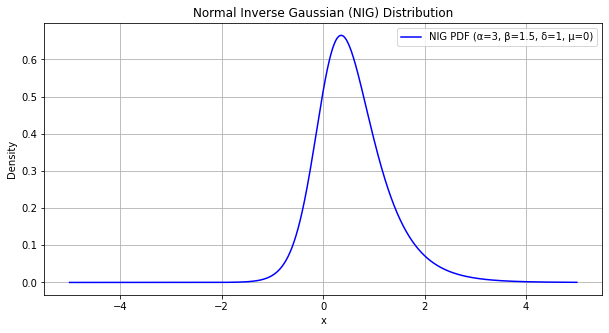

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv  

def nig_pdf(x, alpha=3.0, beta=1.5, delta=1.0, mu=0.0):
    gamma = np.sqrt(alpha**2 - beta**2)
    coef = alpha * delta / np.pi
    z = np.sqrt(delta**2 + (x - mu)**2)
    bessel = kv(1, alpha * z)
    exp_term = np.exp(delta * gamma + beta * (x - mu))
    return coef * bessel * exp_term / z

x = np.linspace(-5, 5, 1000)

y = nig_pdf(x, alpha=3.0, beta=1.5, delta=1.0, mu=0.0)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label="NIG PDF (α=3, β=1.5, δ=1, μ=0)", color="blue")
plt.title("Normal Inverse Gaussian (NIG) Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


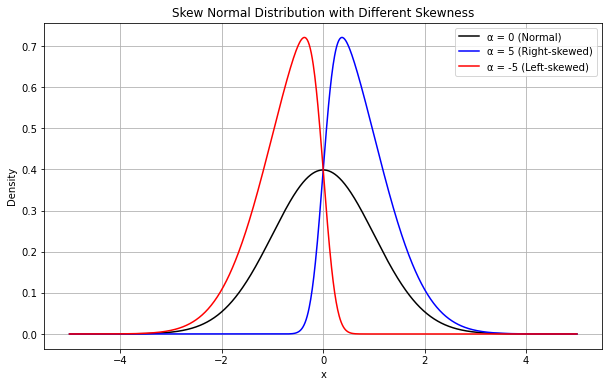

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

x = np.linspace(-5, 5, 1000)

alphas = [0, 5, -5]
colors = ['black', 'blue', 'red']
labels = ['α = 0 (Normal)', 'α = 5 (Right-skewed)', 'α = -5 (Left-skewed)']

plt.figure(figsize=(10, 6))
for alpha, color, label in zip(alphas, colors, labels):
    y = skewnorm.pdf(x, a=alpha)
    plt.plot(x, y, color=color, label=label)

plt.title("Skew Normal Distribution with Different Skewness")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


start -- end ： 2011-10-04  -  2025-04-17
count： 3404
=== Normal Distribution ===
mu = -0.006403, sigma = 0.073549
Log-likelihood = 4053.69
AIC = -8103.38

=== Skew Normal Distribution ===
alpha = -0.000000, loc = -0.006403, scale = 0.073549
Log-likelihood = 4053.69
AIC = -8101.38

=== NIG Distribution ===
alpha = 10.403032, beta = 2.394539, delta = 0.052845, mu = -0.018902
Log-likelihood = 4417.94
AIC = -8827.88



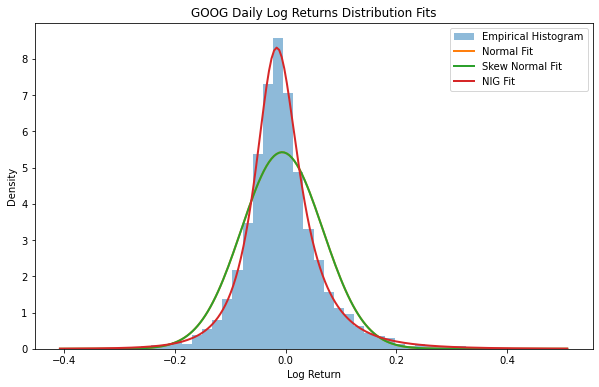

In [81]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import kv as besselk
from scipy.optimize import minimize

api_key = 'WXRBHD42HBDZW2ZO' 
url = "https://www.alphavantage.co/query"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "UVXY",
    "outputsize": "full",
    "apikey": api_key
}

r = requests.get(url, params=params)
data = r.json()


if "Time Series (Daily)" not in data:
    raise ValueError("没有获取到有效数据，请检查 API key 或其它请求参数。")

ts_data = data["Time Series (Daily)"]

records = []
for date_str, daily in ts_data.items():
    records.append({
        "date": pd.to_datetime(date_str),
        "adj_close": float(daily["5. adjusted close"])
    })

df = pd.DataFrame(records)
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
print("start -- end ：", df.date.iloc[0].date(), " - ", df.date.iloc[-1].date())


df["LogReturn"] = np.log(df["adj_close"]).diff()
df.dropna(subset=["LogReturn"], inplace=True)
returns = df["LogReturn"].values
print("count：", len(returns))


mu_norm, sigma_norm = norm.fit(returns)
ll_norm = np.sum(norm.logpdf(returns, loc=mu_norm, scale=sigma_norm))
aic_norm = 2*2 - 2*ll_norm

print("=== Normal Distribution ===")
print(f"mu = {mu_norm:.6f}, sigma = {sigma_norm:.6f}")
print(f"Log-likelihood = {ll_norm:.2f}")
print(f"AIC = {aic_norm:.2f}\n")


def skewnorm_pdf(x, alpha, loc, scale):
    """ Skew Normal PDF： f(x) = 2/scale * φ(z) * Φ(α*z) 其中 z = (x-loc)/scale """
    z = (x - loc) / scale
    return (2.0 / scale) * norm.pdf(z) * norm.cdf(alpha * z)

def skewnorm_logpdf(x, alpha, loc, scale):
    return np.log(skewnorm_pdf(x, alpha, loc, scale) + 1e-32)


def neg_log_likelihood_skewnorm(params, data):
    alpha, loc, scale = params
    if scale <= 0:
        return 1e25 
    return -np.sum(skewnorm_logpdf(data, alpha, loc, scale))


initial_guess_skew = [0, np.mean(returns), np.std(returns)]
bounds_skew = [(-50, 50), (None, None), (1e-9, None)]

result_skew = minimize(neg_log_likelihood_skewnorm, initial_guess_skew,
                         args=(returns,), bounds=bounds_skew, method='L-BFGS-B')

if not result_skew.success:
    print("Skew Normal fit did not converge:", result_skew.message)

alpha_skew, loc_skew, scale_skew = result_skew.x
ll_skew = -result_skew.fun
aic_skew = 2*3 - 2*ll_skew

print("=== Skew Normal Distribution ===")
print(f"alpha = {alpha_skew:.6f}, loc = {loc_skew:.6f}, scale = {scale_skew:.6f}")
print(f"Log-likelihood = {ll_skew:.2f}")
print(f"AIC = {aic_skew:.2f}\n")


def nig_logpdf(x, alpha, beta, delta, mu):
    """
    NIG 的对数PDF定义：
    log(pdf) = log(alpha) + log(delta) - log(pi)
               + delta * sqrt(alpha^2 - beta^2) + beta * (x-mu)
               + log(K1(alpha*sqrt(delta^2+(x-mu)^2))) - log(sqrt(delta^2+(x-mu)^2))
    """
    gamma = np.sqrt(alpha**2 - beta**2)
    dist = np.sqrt(delta**2 + (x - mu)**2)
    log_prefactor = np.log(alpha) + np.log(delta) - np.log(np.pi)
    exponent = delta * gamma + beta * (x - mu)
    log_bessel = np.log(besselk(1, alpha * dist) + 1e-32)
    log_denom = np.log(dist + 1e-32)
    return log_prefactor + exponent + log_bessel - log_denom

def neg_log_likelihood_nig(params, data):
    alpha, beta, delta, mu = params
    if alpha <= abs(beta) or delta <= 0:
        return 1e25
    return -np.sum([nig_logpdf(x, alpha, beta, delta, mu) for x in data])


initial_guess_nig = [5, 0, 0.1, 0]
bounds_nig = [(1e-9, None), (None, None), (1e-9, None), (None, None)]

result_nig = minimize(neg_log_likelihood_nig, initial_guess_nig,
                      args=(returns,), method='L-BFGS-B', bounds=bounds_nig)

if not result_nig.success:
    print("NIG fit did not converge:", result_nig.message)

alpha_nig, beta_nig, delta_nig, mu_nig = result_nig.x
ll_nig = -result_nig.fun
aic_nig = 2*4 - 2*ll_nig

print("=== NIG Distribution ===")
print(f"alpha = {alpha_nig:.6f}, beta = {beta_nig:.6f}, delta = {delta_nig:.6f}, mu = {mu_nig:.6f}")
print(f"Log-likelihood = {ll_nig:.2f}")
print(f"AIC = {aic_nig:.2f}\n")


x_vals = np.linspace(returns.min(), returns.max(), 200)


pdf_norm = norm.pdf(x_vals, loc=mu_norm, scale=sigma_norm)


def skewnorm_pdf_array(x_array, alpha, loc, scale):
    return np.array([skewnorm_pdf(x, alpha, loc, scale) for x in x_array])
pdf_skew_array = skewnorm_pdf_array(x_vals, alpha_skew, loc_skew, scale_skew)


def nig_pdf_array(x_array, alpha, beta, delta, mu):
    vals = []
    for x in x_array:
        dist = np.sqrt(delta**2 + (x - mu)**2)
        numerator = alpha * delta / np.pi * np.exp(delta * np.sqrt(alpha**2 - beta**2) + beta*(x - mu)) * besselk(1, alpha*dist)
        vals.append(numerator / dist)
    return np.array(vals)
pdf_nig_array = nig_pdf_array(x_vals, alpha_nig, beta_nig, delta_nig, mu_nig)

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, density=True, alpha=0.5, label='Empirical Histogram')
plt.plot(x_vals, pdf_norm, label='Normal Fit', lw=2)
plt.plot(x_vals, pdf_skew_array, label='Skew Normal Fit', lw=2)
plt.plot(x_vals, pdf_nig_array, label='NIG Fit', lw=2)
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.title("GOOG Daily Log Returns Distribution Fits")
plt.legend()
plt.show()



Q4

In [82]:
import numpy as np
import pandas as pd
from scipy import stats
import warnings
import time
import inspect

warnings.filterwarnings('ignore')


ALPHA = 0.05           
N_SIMULATIONS = 10000   
np.random.seed(42)     


df_portfolio = pd.read_csv("initial_portfolio.csv")
df_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
df_rf = pd.read_csv("rf.csv", parse_dates=["Date"])

df_prices.set_index("Date", inplace=True)
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
df_prices.dropna(axis=1, how='all', inplace=True)
daily_returns = df_prices.pct_change()


daily_returns = daily_returns.reset_index().merge(df_rf, how="left", on="Date").set_index("Date")
daily_returns["rf"] = pd.to_numeric(daily_returns["rf"], errors='coerce').ffill()
daily_returns.dropna(how="all", inplace=True)


estimation_data = daily_returns[daily_returns.index.year <= 2023].copy()
all_symbols = df_portfolio["Symbol"].unique().tolist()
dist_symbols = [s for s in all_symbols if s in estimation_data.columns]
if "rf" in dist_symbols:
    dist_symbols.remove("rf")
estimation_returns = estimation_data[dist_symbols].dropna(how="all")


def_candidates = {
    "Normal":   stats.norm,
    "Gen T":    stats.t,              
    "NIG":      stats.norminvgauss,
    "SkewNorm": stats.skewnorm
}

def calc_aicc(log_likelihood, n, k):
    aic = 2*k - 2*log_likelihood
    if (n - k - 1) > 0:
        return aic + (2*(k**2)+2*k)/(n - k - 1)
    else:
        return aic

best_fits = []
fitting_records = {}

for sym in dist_symbols:
    data_series = estimation_returns[sym].dropna()
    if len(data_series) < 2:
        continue
    n_data = len(data_series)
    array_data = data_series.values

    best_aicc = np.inf
    chosen_dist_name = None
    chosen_params = None

    for nm, dist_obj in def_candidates.items():
        try:
            params = dist_obj.fit(array_data)
            loglik = np.sum(dist_obj.logpdf(array_data, *params))
            k = len(params)
            aicc_val = calc_aicc(loglik, n_data, k)

            if aicc_val < best_aicc:
                best_aicc = aicc_val
                chosen_dist_name = nm
                chosen_params = params
        except Exception:
            continue

    if chosen_dist_name is not None:
        final_params = list(chosen_params)
        dist_obj = def_candidates[chosen_dist_name]
        param_names = dist_obj.shapes 
        if param_names is None:
            param_names = ""  
        else:
            param_names = param_names.replace(' ', '')

  
        loc_scale_params = []
        sig = inspect.signature(dist_obj._parse_args)
        if 'loc' in sig.parameters:
            loc_scale_params.append('loc')
        if 'scale' in sig.parameters:
            loc_scale_params.append('scale')

        param_list = [p.strip() for p in param_names.split(',') if p.strip()]
        param_indices = {}
        current_idx = 0
        for p_ in param_list:
            param_indices[p_] = current_idx
            current_idx += 1
        if 'loc' in loc_scale_params:
            param_indices['loc'] = current_idx
            current_idx += 1
        if 'scale' in loc_scale_params:
            param_indices['scale'] = current_idx
            current_idx += 1

        if 'loc' in param_indices:
            loc_idx = param_indices['loc']
            final_params[loc_idx] = 0.0

        final_params = tuple(final_params)

        fitting_records[sym] = {
            "dist_name": chosen_dist_name,
            "params": final_params,
            "dist_obj": dist_obj
        }
        best_fits.append({
            "Symbol": sym,
            "BestDist": chosen_dist_name,
            "AICc": best_aicc,
            "Params": final_params
        })
        print(f"  {sym}: Best fit = {chosen_dist_name} (AICc={best_aicc:.2f}), "
              f"Params={np.round(final_params, 4)}")

df_fits = pd.DataFrame(best_fits)
if df_fits.empty:
    print("error")



ppf_cache = {}
quantile_points = 1000
u_values = np.linspace(0.001, 0.999, quantile_points)

for sym in fitting_records:
    dist_info = fitting_records[sym]
    dist_obj = dist_info["dist_obj"]
    params = dist_info["params"]
    ppf_values = dist_obj.ppf(u_values, *params)

    bad_mask = ~np.isfinite(ppf_values)
    if np.any(bad_mask):
        good_vals = ppf_values[~bad_mask]
        if len(good_vals) == 0:
            ppf_values[bad_mask] = 0
        else:
            median_val = np.median(good_vals)
            ppf_values[bad_mask] = median_val

    ppf_cache[sym] = {
        'u_values': u_values,
        'ppf_values': ppf_values
    }
    
    
def get_weights_for_portfolio(port_id):
    subp = df_portfolio[df_portfolio["Portfolio"] == port_id]
    if subp.empty:
        return [], np.array([]), 0.0


    try:
        lastp = df_prices.loc[df_prices.index <= '2023-12-31'].iloc[-1]
    except:
        lastp = df_prices.iloc[-1]

    vals = []
    syms = []
    for _, row in subp.iterrows():
        s_ = row["Symbol"]
        h_ = row["Holding"]
        if s_ in lastp.index and not pd.isna(lastp[s_]):
            val_ = h_ * lastp[s_]
            if val_ != 0:
                syms.append(s_)
                vals.append(val_)

    if not vals:
        return [], np.array([]), 0.0

    vals = np.array(vals)
    tot_val = vals.sum()
    if tot_val <= 0:
        return syms, np.array([]), 0.0

    wts = vals / tot_val
    return syms, wts, tot_val

def get_var_es_from_sim(sim_ret, alpha):
    if len(sim_ret) < 1:
        return np.nan, np.nan
    sr = np.sort(sim_ret)
    idx = int(alpha * len(sr))
    var_ = -sr[idx]
    es_ = -np.mean(sr[:idx+1]) if idx >= 0 else var_
    return var_, es_


copula_results = []
mvn_results = []

all_port_ids = df_portfolio["Portfolio"].unique()

for pid in all_port_ids:
    if pid == 'Total':  
        continue

    syms, wts, pval = get_weights_for_portfolio(pid)
    if pval <= 0 or len(syms) == 0:
        continue

    if not np.isclose(wts.sum(), 1.0):
        wts = wts / wts.sum()

    sub_port_ret = estimation_returns[syms].dropna(how='any')
    if sub_port_ret.shape[0] < 2 or sub_port_ret.shape[1] < 2:
        continue

    try:
        
        sp_corr = sub_port_ret.corr(method='spearman').values
        min_eig = np.min(np.linalg.eigvalsh(sp_corr))
        if min_eig <= 1e-12:
            fix_val = max(0, -min_eig + 1e-10)
            sp_corr += np.eye(sp_corr.shape[0]) * fix_val

        L = np.linalg.cholesky(sp_corr)
        Z_raw = np.random.randn(N_SIMULATIONS, len(syms))
        Z_corr = Z_raw @ L.T
        U_sim = stats.norm.cdf(Z_corr)
        np.clip(U_sim, 1e-8, 1 - 1e-8, out=U_sim)
        big_sim = np.zeros((N_SIMULATIONS, len(syms)))
        for j, s_ in enumerate(syms):
            if s_ in ppf_cache:
                cache = ppf_cache[s_]
                big_sim[:, j] = np.interp(U_sim[:, j],
                                          cache['u_values'],
                                          cache['ppf_values'])
            else:
                fallback_std = sub_port_ret[s_].std()
                big_sim[:, j] = stats.norm.ppf(U_sim[:, j], loc=0, scale=fallback_std)

        port_ret = big_sim @ wts

        var_, es_ = get_var_es_from_sim(port_ret, ALPHA)
        var_pct = var_ * 100
        es_pct = es_ * 100
        print(f"  Copula: VaR={var_pct:.4f}% (${var_*pval:.2f}), ES={es_pct:.4f}% (${es_*pval:.2f})")

        copula_results.append({
            "Portfolio": pid,
            "Method": "Copula",
            "Portfolio Value": pval,
            "VaR": var_ * pval,
            "ES": es_ * pval,
            "VaR(%)": var_pct,
            "ES(%)": es_pct
        })
    except Exception as e:
        print(f"  Copula error: {e}")


    try:
        cov_mat = sub_port_ret.cov().values
        min_eig2 = np.min(np.linalg.eigvalsh(cov_mat))
        if min_eig2 < -1e-12:
            fix_val2 = -min_eig2 + 1e-10
            cov_mat += np.eye(cov_mat.shape[0]) * fix_val2

        z_val = stats.norm.ppf(ALPHA)
        var_m = wts.T @ cov_mat @ wts
        if var_m < 0:
            var_m = 0

        sigma_m = np.sqrt(var_m)
        if sigma_m < 1e-12:
            VaR_mvn = 0
            ES_mvn = 0
        else:
            VaR_mvn = -(0 + z_val * sigma_m)
            pdf_z = stats.norm.pdf(z_val)
            ES_mvn = -(0 - sigma_m * pdf_z / ALPHA)

        VaR_mvn_pct = VaR_mvn * 100
        ES_mvn_pct = ES_mvn * 100
        print(f"  MVN:    VaR={VaR_mvn_pct:.4f}% (${VaR_mvn*pval:.2f}), "
              f"ES={ES_mvn_pct:.4f}% (${ES_mvn*pval:.2f})")

        mvn_results.append({
            "Portfolio": pid,
            "Method": "MVN",
            "Portfolio Value": pval,
            "VaR": VaR_mvn * pval,
            "ES": ES_mvn * pval,
            "VaR(%)": VaR_mvn_pct,
            "ES(%)": ES_mvn_pct
        })
    except Exception as e:
        print(f"  MVN error: {e}")


final_rows = []
final_rows.extend(copula_results)
final_rows.extend(mvn_results)

df_result = pd.DataFrame(final_rows)
print(df_result)



  WFC: Best fit = Gen T (AICc=-1320.37), Params=[5.0037 0.     0.0137]
  ETN: Best fit = Gen T (AICc=-1353.58), Params=[3.8783 0.     0.012 ]
  AMZN: Best fit = Gen T (AICc=-1232.15), Params=[5.9219 0.     0.0169]
  QCOM: Best fit = Gen T (AICc=-1259.42), Params=[5.2207 0.     0.0156]
  LMT: Best fit = Gen T (AICc=-1589.31), Params=[3.7033 0.     0.0074]
  KO: Best fit = Gen T (AICc=-1690.34), Params=[5.2155 0.     0.0066]
  JNJ: Best fit = Gen T (AICc=-1611.97), Params=[3.605 0.    0.007]
  ISRG: Best fit = Gen T (AICc=-1311.49), Params=[4.7002 0.     0.0137]
  XOM: Best fit = Gen T (AICc=-1363.94), Params=[7.8807 0.     0.0136]
  MDT: Best fit = Gen T (AICc=-1448.71), Params=[4.583  0.     0.0104]
  DHR: Best fit = Gen T (AICc=-1395.12), Params=[5.3055 0.     0.0119]
  PLD: Best fit = Gen T (AICc=-1337.94), Params=[6.6757 0.     0.0139]
  BA: Best fit = Gen T (AICc=-1335.71), Params=[4.703  0.     0.0131]
  PG: Best fit = Gen T (AICc=-1625.03), Params=[5.5198 0.     0.0076]
  MRK: Be

In [83]:
final_rows = []
final_rows.extend(copula_results)
final_rows.extend(mvn_results)

df_result = pd.DataFrame(final_rows)
print(df_result)

warnings.filterwarnings('default')

  Portfolio  Method  Portfolio Value          VaR           ES    VaR(%)  \
0         A  Copula    295444.608200  4214.126898  5601.328470  1.426368   
1         B  Copula    280904.482409  3685.306007  4898.606073  1.311943   
2         C  Copula    267591.439955  3780.627132  4975.982111  1.412836   
3         A     MVN    295444.608200  4197.966533  5264.419394  1.420898   
4         B     MVN    280904.482409  3668.822444  4600.851358  1.306075   
5         C     MVN    267591.439955  3684.828997  4620.924221  1.377035   

      ES(%)  
0  1.895898  
1  1.743869  
2  1.859545  
3  1.781863  
4  1.637870  
5  1.726858  


In [84]:
np.random.seed(42)   
total_holdings = {}
for _, row in initial_portfolio.iterrows():
    sym = row["Symbol"]
    if sym in best_fit_models:                      
        total_holdings[sym] = total_holdings.get(sym, 0) + row["Holding"]

try:
    last_px = prices.loc[prices.index <= "2023-12-31"].iloc[-1]
except IndexError:
    last_px = prices.iloc[-1]

total_syms, total_vals = [], []
for sym, shares in total_holdings.items():
    if sym in last_px.index and not pd.isna(last_px[sym]):
        total_syms.append(sym)
        total_vals.append(shares * last_px[sym])

total_vals   = np.asarray(total_vals, dtype=float)
total_value  = total_vals.sum()
total_wts    = total_vals / total_value

weights_vec     = total_wts
est_ret_subset  = estimation_returns[total_syms].dropna()
num_assets      = len(total_syms)

VaR_tot_cop = ES_tot_cop = np.nan
try:
    spearman_corr      = est_ret_subset.corr(method="spearman").values
    chol_L             = np.linalg.cholesky(spearman_corr + 1e-10*np.eye(num_assets))
    Z_rand             = np.random.randn(N_SIMULATIONS, num_assets) @ chol_L.T
    U_rand             = stats.norm.cdf(Z_rand)
    X_rand             = np.zeros_like(U_rand)
    for j, sym in enumerate(total_syms):
        cache          = ppf_cache[sym]
        X_rand[:, j]   = np.interp(U_rand[:, j], cache["u_values"], cache["ppf_values"])
    port_sim_ret       = X_rand @ weights_vec
    sorted_ret         = np.sort(port_sim_ret)
    idx                = int(ALPHA * len(sorted_ret))
    VaR_tot_cop        = -sorted_ret[idx]
    ES_tot_cop         = -sorted_ret[:idx+1].mean()
    print(f"\nTotal Copula: VaR={VaR_tot_cop*100:.4f}% "
          f"(${VaR_tot_cop*total_value:.2f}), ES={ES_tot_cop*100:.4f}% "
          f"(${ES_tot_cop*total_value:.2f})")
except Exception as e:
    print("Total Copula error:", e)

VaR_tot_mvn = ES_tot_mvn = np.nan
try:
    cov_tot            = est_ret_subset.cov().values
    port_sigma         = np.sqrt(weights_vec.T @ cov_tot @ weights_vec)
    z_alpha            = stats.norm.ppf(ALPHA)
    VaR_tot_mvn        = -(z_alpha * port_sigma)
    ES_tot_mvn         = -(port_sigma * stats.norm.pdf(z_alpha) / ALPHA)
    print(f"Total MVN:    VaR={VaR_tot_mvn*100:.4f}% "
          f"(${VaR_tot_mvn*total_value:.2f}), ES={ES_tot_mvn*100:.4f}% "
          f"(${ES_tot_mvn*total_value:.2f})")
except Exception as e:
    print("Total MVN error:", e)



Total Copula: VaR=1.3399% ($11308.02), ES=1.7968% ($15163.55)
Total MVN:    VaR=1.3254% ($11185.53), ES=-1.6621% ($-14027.11)


Q5

In [85]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')


CONF = 0.95              
ALPHA = 1 - CONF         
N_SIMULATIONS = 10000    
np.random.seed(42)       


def simulate_copula(sym_list, corr, wts):
    n = len(sym_list)
    chol = np.linalg.cholesky(corr)
    z = np.random.standard_normal((N_SIMULATIONS, n)) @ chol.T 
    u = norm.cdf(z)                                    
    x = np.empty_like(u)
    
    for j, s in enumerate(sym_list):
        if s in ppf_cache:
            cache = ppf_cache[s]
            x[:, j] = np.interp(u[:, j], cache['u_values'], cache['ppf_values'])
        else:
            std = estimation_returns[s].std()
            x[:, j] = norm.ppf(u[:, j], loc=0, scale=std)
    
    port_ret = x @ wts
    return port_ret, x


def es_and_contribs(sym_list, wts, corr):
    port_ret, asset_ret = simulate_copula(sym_list, corr, wts)
    thresh = np.quantile(port_ret, ALPHA)
    tail_idx = port_ret <= thresh
    tail_R = asset_ret[tail_idx]              
    tail_p = port_ret[tail_idx]                

    ES = -tail_p.mean()
    RCs = -wts * tail_R.mean(axis=0)          
    return ES, RCs


def risk_parity_objective(wts, sym_list, corr):
    wts = np.maximum(wts, 1e-10)          
    wts = wts / wts.sum()                 
    ES, RCs = es_and_contribs(sym_list, wts, corr)
    target = ES / len(RCs)                
    return np.sum((RCs - target) ** 2)


def fit_risk_parity(sym_list, corr):
    n = len(sym_list)
    x0 = np.ones(n) / n                   
    bounds = [(0, 1) for _ in range(n)]   
    cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1})  
    
    try:
        res = minimize(
            risk_parity_objective, 
            x0, 
            args=(sym_list, corr),
            method='SLSQP', 
            bounds=bounds, 
            constraints=cons,
            options={'ftol': 1e-10, 'maxiter': 500, 'disp': False}
        )
        
        if res.success:
            w = res.x / res.x.sum()  
            return w, True
        else:
            print(f"  Optimization failed: {res.message}")
            return x0, False
    except Exception as e:
        print(f"  Error in optimization: {e}")
        return x0, False



print("\n===== Building Correlation Matrices =====")
corr_dict = {}

for pid in df_portfolio["Portfolio"].unique():
    df_sub = df_portfolio[df_portfolio["Portfolio"] == pid]
    symbols = df_sub["Symbol"].tolist()
    
    symbols = [s for s in symbols if s in fitting_records and s in estimation_returns.columns]
    
    if len(symbols) < 2:
        print(f"  Portfolio {pid}: Not enough assets with fitted distributions")
        continue
    
    corr = estimation_returns[symbols].corr(method='spearman').fillna(0).values
    
    min_eig = np.min(np.linalg.eigvalsh(corr))
    if min_eig < 1e-8:
        fix_val = max(0, 1e-8 - min_eig)
        corr += np.eye(len(symbols)) * fix_val
    
    corr_dict[str(pid)] = (symbols, corr)
    print(f"  Portfolio {pid}: Built correlation matrix for {len(symbols)} assets")


print("\n===== Constructing Risk Parity Portfolios =====")
risk_parity_weights = {}

for pid, (symbols, corr) in corr_dict.items():
    print(f"\nOptimizing Risk Parity for Portfolio {pid}")
    
    weights, success = fit_risk_parity(symbols, corr)
    risk_parity_weights[pid] = pd.Series(weights, index=symbols)
    
    ES, RCs = es_and_contribs(symbols, weights, corr)
    status = "success" if success else "fallback to equal weights"
    
    print(f"  Optimization {status} - Portfolio ES: {ES:.6f}")
    print("  Risk Contributions:")
    for sym, rc in zip(symbols, RCs):
        weight = weights[symbols.index(sym)]
        print(f"    {sym}: weight={weight:.4f}, risk_contrib={rc:.6f}, pct={rc/ES:.2%}")

if len(risk_parity_weights) > 0:
    portfolio_ids = list(risk_parity_weights.keys())
    
    all_symbols = set()
    for pid in portfolio_ids:
        all_symbols.update(risk_parity_weights[pid].index)
    
    total_weights = {}
    n_portfolios = len(portfolio_ids)
    
    for sym in all_symbols:
        weight_sum = 0
        for pid in portfolio_ids:
            weights = risk_parity_weights[pid]
            if sym in weights.index:
                weight_sum += weights[sym] / n_portfolios
        
        if weight_sum > 0:
            total_weights[sym] = weight_sum
    
    total_sum = sum(total_weights.values())
    if total_sum > 0:
        total_weights = {sym: w/total_sum for sym, w in total_weights.items()}
    
    risk_parity_weights["Total"] = pd.Series(total_weights)
    print("\nCreated Total portfolio by equal-weighting sub-portfolios")


print("\n===== Tracking Portfolio Performance =====")
holding_data = daily_returns[daily_returns.index.year > 2023]
market_returns_hold = holding_data['SPY'] - holding_data['rf']

risk_parity_daily_weights = {}
risk_parity_port_returns = {}

for pid, weights in risk_parity_weights.items():
    symbols = weights.index.tolist()
    initial_weights = weights.values.copy()

    if len(symbols) == 0:
        continue
    
    print(f"Tracking performance for Portfolio {pid} with {len(symbols)} assets")
    
    last_weights = initial_weights.copy()
    port_returns = []
    daily_weights = []
    
    for date in holding_data.index:
        daily_ret = holding_data.loc[date, symbols].values
        if np.isnan(daily_ret).any():
            daily_ret = np.nan_to_num(daily_ret, nan=0.0)
        
        port_return = np.sum(last_weights * daily_ret)
        port_returns.append(port_return)
        daily_weights.append(last_weights.copy())
        
        current_values = last_weights * (1 + daily_ret)
        total_value = np.sum(current_values)
        
        if np.isclose(total_value, 0):
            last_weights = np.zeros(len(symbols))
        else:
            last_weights = current_values / total_value
    
    risk_parity_daily_weights[pid] = pd.DataFrame(daily_weights, index=holding_data.index, columns=symbols)
    risk_parity_port_returns[pid] = pd.Series(port_returns, index=holding_data.index)


print("\n===== CAPM Attribution Analysis =====")

def carino_link(r_series):
    tot = (1 + r_series).prod() - 1
    if np.isclose(tot, 0):
        k = 1.0
    else:
        k = np.log1p(tot) / tot
    
    lk = np.ones_like(r_series)
    non_zero_mask = ~np.isclose(r_series, 0)
    lk[non_zero_mask] = np.log1p(r_series[non_zero_mask]) / (r_series[non_zero_mask] * k)
    
    return pd.Series(lk, index=r_series.index)

attribution_results = []
risk_attribution_results = []

for pid, port_returns in risk_parity_port_returns.items():
    sys_comp = pd.Series(0.0, index=port_returns.index)
    
    if pid != "Total":
        symbols = risk_parity_daily_weights[pid].columns
        
        for date in port_returns.index:
            r_m = market_returns_hold.loc[date] if date in market_returns_hold.index else 0
            weights = risk_parity_daily_weights[pid].loc[date].values
            
            sys_t = 0.0
            for i, sym in enumerate(symbols):
                if sym in results_capm_all.get(pid, {}):
                    beta = results_capm_all[pid][sym][1]
                    sys_t += weights[i] * beta * r_m
            
            sys_comp[date] = sys_t
    else:
        n_portfolios = sum(1 for p in risk_parity_weights.keys() if p != "Total")
        for date in port_returns.index:
            r_m = market_returns_hold.loc[date] if date in market_returns_hold.index else 0
            sys_t = 0.0
            
            for sub_pid in [p for p in risk_parity_weights.keys() if p != "Total"]:
                if sub_pid not in risk_parity_daily_weights:
                    continue
                    
                sub_weights = risk_parity_daily_weights[sub_pid].loc[date]
                sub_symbols = sub_weights.index
                
                for sym, weight in zip(sub_symbols, sub_weights):
                    if sym in results_capm_all.get(sub_pid, {}):
                        beta = results_capm_all[sub_pid][sym][1]
                        sys_t += (weight * beta * r_m) / n_portfolios
            
            sys_comp[date] = sys_t
    
    idio_comp = port_returns - sys_comp
    
    valid_mask = (~pd.isna(port_returns)) & (~pd.isna(sys_comp)) & (~pd.isna(idio_comp))
    valid_returns = port_returns[valid_mask]
    valid_sys = sys_comp[valid_mask]
    valid_idio = idio_comp[valid_mask]
    
    if len(valid_returns) == 0:
        print(f"Warning: Portfolio {pid} has no valid data for attribution")
        continue
    
    link_factors = carino_link(valid_returns)
    
    total_return = (1 + valid_returns).prod() - 1
    sys_return = (valid_sys * link_factors).sum()
    idio_return = (valid_idio * link_factors).sum()
    
    total_vol = valid_returns.std(ddof=0)
    
    if total_vol > 0 and len(valid_returns) > 1:
        cov_sys = np.cov(valid_sys, valid_returns, ddof=0)[0, 1]
        cov_idio = np.cov(valid_idio, valid_returns, ddof=0)[0, 1]
        
        sys_risk = cov_sys / total_vol
        idio_risk = cov_idio / total_vol
    else:
        sys_risk = 0
        idio_risk = 0
    
    if pid != "Total":
        symbols = risk_parity_daily_weights[pid].columns
        initial_weights = risk_parity_weights[pid].values
        
        residual_vars = np.zeros(len(symbols))
        for i, sym in enumerate(symbols):
            if sym in residual_var_all.get(pid, {}):
                residual_vars[i] = residual_var_all[pid][sym]
        
        expected_idio_risk = np.sqrt(np.sum(initial_weights**2 * residual_vars))
    else:
        expected_idio_risk = np.nan
    
    attribution_results.append({
        "Portfolio": pid,
        "Method": "Risk Parity (ES)",
        "Total Return": total_return,
        "Systematic Return": sys_return,
        "Idiosyncratic Return": idio_return
    })
    
    risk_attribution_results.append({
        "Portfolio": pid,
        "Method": "Risk Parity (ES)",
        "Total Risk": total_vol,
        "Systematic Risk": sys_risk,
        "Idiosyncratic Risk": idio_risk,
        "Expected Idio Risk": expected_idio_risk
    })
    
    print(f"\nPortfolio {pid} Attribution:")
    print(f"  Total Return: {total_return:.4%}")
    print(f"    Systematic: {sys_return:.4%}")
    print(f"    Idiosyncratic: {idio_return:.4%}")
    print(f"  Total Risk (Daily): {total_vol:.4%}")
    print(f"    Systematic Risk: {sys_risk:.4%}")
    print(f"    Idiosyncratic Risk: {idio_risk:.4%}")
    print(f"    Expected Idio Risk: {expected_idio_risk:.4%}")


attribution_df = pd.DataFrame(attribution_results).round(4)
risk_attribution_df = pd.DataFrame(risk_attribution_results).round(4)

print("\n===== Risk Parity Portfolio Return Attribution Summary =====")
print(attribution_df)

print("\n===== Risk Parity Portfolio Risk Attribution Summary =====")
print(risk_attribution_df)



===== Building Correlation Matrices =====
  Portfolio A: Built correlation matrix for 33 assets
  Portfolio B: Built correlation matrix for 33 assets
  Portfolio C: Built correlation matrix for 33 assets

===== Constructing Risk Parity Portfolios =====

Optimizing Risk Parity for Portfolio A
  Optimization success - Portfolio ES: 0.018773
  Risk Contributions:
    WFC: weight=0.0301, risk_contrib=0.000697, pct=3.71%
    ETN: weight=0.0300, risk_contrib=0.000650, pct=3.46%
    AMZN: weight=0.0319, risk_contrib=0.000795, pct=4.24%
    QCOM: weight=0.0311, risk_contrib=0.000965, pct=5.14%
    LMT: weight=0.0320, risk_contrib=0.000206, pct=1.10%
    KO: weight=0.0292, risk_contrib=0.000189, pct=1.00%
    JNJ: weight=0.0294, risk_contrib=0.000211, pct=1.13%
    ISRG: weight=0.0300, risk_contrib=0.000721, pct=3.84%
    XOM: weight=0.0350, risk_contrib=0.000471, pct=2.51%
    MDT: weight=0.0329, risk_contrib=0.000455, pct=2.43%
    DHR: weight=0.0283, risk_contrib=0.000481, pct=2.56%
    PLD

In [86]:
print("\n===== Risk Parity Portfolio Return Attribution Summary =====")
print(attribution_df)

print("\n===== Risk Parity Portfolio Risk Attribution Summary =====")
print(risk_attribution_df)


===== Risk Parity Portfolio Return Attribution Summary =====
  Portfolio            Method  Total Return  Systematic Return  \
0         A  Risk Parity (ES)        0.2394             0.2087   
1         B  Risk Parity (ES)        0.2559             0.1860   
2         C  Risk Parity (ES)        0.3972             0.2229   
3     Total  Risk Parity (ES)        0.2975             0.2058   

   Idiosyncratic Return  
0                0.0306  
1                0.0698  
2                0.1744  
3                0.0917  

===== Risk Parity Portfolio Risk Attribution Summary =====
  Portfolio            Method  Total Risk  Systematic Risk  \
0         A  Risk Parity (ES)      0.0082           0.0077   
1         B  Risk Parity (ES)      0.0068           0.0064   
2         C  Risk Parity (ES)      0.0088           0.0078   
3     Total  Risk Parity (ES)      0.0076           0.0077   

   Idiosyncratic Risk  Expected Idio Risk  
0              0.0005              0.0027  
1              0.0

In [87]:
risk_parity_daily_weights

{'A':                  WFC       ETN      AMZN      QCOM       LMT        KO  \
 Date                                                                     
 2024-01-02  0.030073  0.029961  0.031865  0.031125  0.031984  0.029225   
 2024-01-03  0.030179  0.029760  0.031484  0.030217  0.032229  0.029705   
 2024-01-04  0.030050  0.029300  0.031459  0.029918  0.032734  0.030043   
 2024-01-05  0.030415  0.029468  0.030626  0.029602  0.032639  0.029937   
 2024-01-08  0.030685  0.029396  0.030644  0.029603  0.032409  0.029771   
 ...              ...       ...       ...       ...       ...       ...   
 2024-12-27  0.036248  0.034507  0.038352  0.028021  0.028401  0.025562   
 2024-12-30  0.036212  0.034223  0.038103  0.028019  0.028573  0.025722   
 2024-12-31  0.036259  0.034375  0.038110  0.027855  0.028564  0.025836   
 2025-01-02  0.036216  0.034364  0.037827  0.027716  0.028751  0.025963   
 2025-01-03  0.036061  0.034252  0.037835  0.027621  0.028431  0.025697   
 
                  

In [88]:
risk_parity_port_returns

{'A': Date
 2024-01-02   -0.001296
 2024-01-03   -0.008940
 2024-01-04    0.000191
 2024-01-05    0.004070
 2024-01-08    0.011124
                 ...   
 2024-12-27   -0.008093
 2024-12-30   -0.011123
 2024-12-31   -0.001214
 2025-01-02    0.003562
 2025-01-03    0.015336
 Length: 254, dtype: float64,
 'B': Date
 2024-01-02   -0.001680
 2024-01-03   -0.005783
 2024-01-04   -0.000134
 2024-01-05    0.001149
 2024-01-08    0.011038
                 ...   
 2024-12-27   -0.007755
 2024-12-30   -0.011679
 2024-12-31   -0.000540
 2025-01-02   -0.000615
 2025-01-03    0.006298
 Length: 254, dtype: float64,
 'C': Date
 2024-01-02   -0.006916
 2024-01-03   -0.009068
 2024-01-04   -0.000947
 2024-01-05    0.000077
 2024-01-08    0.012431
                 ...   
 2024-12-27   -0.013119
 2024-12-30   -0.013271
 2024-12-31   -0.005632
 2025-01-02   -0.003953
 2025-01-03    0.015970
 Length: 254, dtype: float64,
 'Total': Date
 2024-01-02   -0.003297
 2024-01-03   -0.007928
 2024-01-04   -0.00029